In [69]:
import matplotlib.gridspec as gridspec

In [1]:
from functools import partial

import jax.lax
import jax.numpy as jnp
import jaxopt
import numpy as np
from jax import jit, grad
from matplotlib import pyplot as plt
from jax.experimental import checkify

from slimpletic import DiscretisedSystem, SolverScan, GGLBundle

q0 = jnp.array([0.0])
pi0 = jnp.array([1.0])
t0 = 0
iterations = 100
dt = 0.1
dof = 1
t = t0 + dt * np.arange(0, iterations + 1)

ggl_bundle = GGLBundle(r=0)


In [2]:
@jit
def compute_action(state, embedding):
    state_dof = state.size
    return jax.lax.fori_loop(
        0, state_dof ** 2,
        lambda i, acc: acc + (embedding[i] * state[i // state_dof] * state[i % state_dof]),
        0.0
    )


def embedded_lagrangian(q, v, t, embedding):
    return compute_action(jnp.concat([q, v], axis=0), embedding)


def plot_comparison(embedding):
    actual_q, actual_pi = embedded_system_solver.integrate(
        q0=q0,
        pi0=pi0,
        t0=t0,
        iterations=iterations,
        additional_data=embedding
    )

    plt.plot(t, expected_q)
    plt.plot(t, actual_q, linestyle='dashed')
    plt.show()


In [3]:
# The system which will be used when computing the loss function.
embedded_system_solver = SolverScan(DiscretisedSystem(
    dt=dt,
    ggl_bundle=ggl_bundle,
    lagrangian=embedded_lagrangian,
    k_potential=None,
    pass_additional_data=True
))

true_embedding = jnp.array([-0.5, 0, 0, 0.5])


def rms(x, y):
    return jnp.sqrt(jnp.mean((x - y) ** 2))


In [4]:
expected_q, expected_pi = embedded_system_solver.integrate(
    q0=q0,
    pi0=pi0,
    t0=t0,
    iterations=iterations,
    additional_data=jnp.array([-0.5, 0, 0, 0.5]),
)

INFO: jaxopt.GradientDescent: Iter: 1 Distance btw Iterates (stop. crit.): 0.24999999999999997 Stepsize:2.0 
INFO: jaxopt.GradientDescent: Iter: 2 Distance btw Iterates (stop. crit.): 0.25000000000000006 Stepsize:4.0 
INFO: jaxopt.GradientDescent: Iter: 3 Distance btw Iterates (stop. crit.): 0.10912323743733951 Stepsize:2.0 
INFO: jaxopt.GradientDescent: Iter: 4 Distance btw Iterates (stop. crit.): 0.06054338542680608 Stepsize:0.5 
INFO: jaxopt.GradientDescent: Iter: 5 Distance btw Iterates (stop. crit.): 0.5072192052546373 Stepsize:0.0625 
INFO: jaxopt.GradientDescent: Iter: 6 Distance btw Iterates (stop. crit.): 0.053712002600591946 Stepsize:0.0625 
INFO: jaxopt.GradientDescent: Iter: 7 Distance btw Iterates (stop. crit.): 0.1802900572394579 Stepsize:0.03125 
INFO: jaxopt.GradientDescent: Iter: 8 Distance btw Iterates (stop. crit.): 0.0020485792399171834 Stepsize:0.015625 
INFO: jaxopt.GradientDescent: Iter: 9 Distance btw Iterates (stop. crit.): 0.2558876155347192 Stepsize:0.0039062

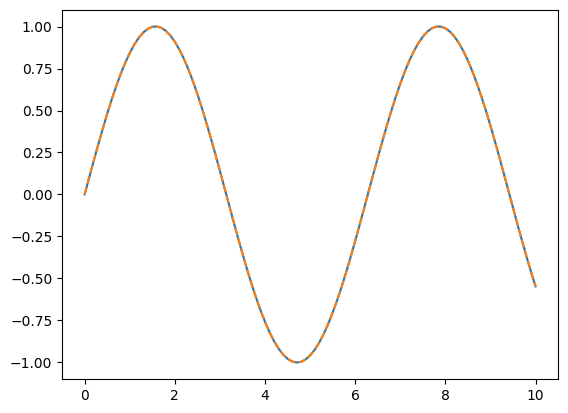

In [5]:
# Dead stupid loss function, this will say if we are using jaxopt GradientDescent class correctly.
def dead_stupid_loss_fn(embedding: jnp.ndarray, _target_q: jnp.ndarray, _target_pi: jnp.ndarray):
    return jnp.sqrt(jnp.mean((embedding - true_embedding) ** 2))


dsl_results = jaxopt.GradientDescent(
    dead_stupid_loss_fn,
    maxiter=1000,
    verbose=True,
).run(
    jnp.array(np.random.rand((2 * dof) ** 2)),
    expected_q,
    expected_pi
).params

plot_comparison(dsl_results)

In [6]:
@jit
def loss_fn(embedding: jnp.ndarray, target_q: jnp.ndarray, target_pi: jnp.ndarray):
    q, pi = embedded_system_solver.integrate(
        q0=q0,
        pi0=pi0,
        t0=t0,
        iterations=iterations,
        additional_data=embedding
    )

    return rms(q, target_q) + rms(pi, target_pi)

In [8]:
results = jaxopt.GradientDescent(
    loss_fn,
    maxiter=1000,
    verbose=True,
).run(
    jnp.array(np.random.rand((2 * dof) ** 2)),
    expected_q,
    expected_pi
).params

INFO: jaxopt.GradientDescent: Iter: 1 Distance btw Iterates (stop. crit.): 1.4074988488777754e+20 Stepsize:6.103515625e-05 
INFO: jaxopt.GradientDescent: Iter: 2 Distance btw Iterates (stop. crit.): 0.0 Stepsize:0.0001220703125 


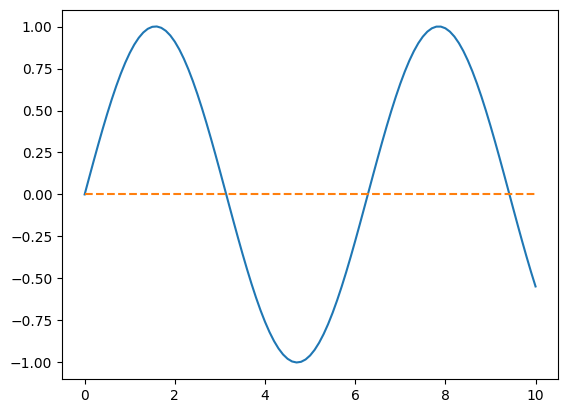

In [9]:
plot_comparison(results)

In [10]:
results

Array([-5.01562898e+14, -3.48777742e+12, -3.48777742e+12,  8.57603556e+15],      dtype=float64)

In [11]:
jaxopt.GradientDescent(
    loss_fn,
    maxiter=1000,
    verbose=True,
    maxls=100
).run(
    jnp.array(np.random.rand((2 * dof) ** 2)),
    expected_q,
    expected_pi
).params

INFO: jaxopt.GradientDescent: Iter: 1 Distance btw Iterates (stop. crit.): 52299.92392881622 Stepsize:6.103515625e-05 
INFO: jaxopt.GradientDescent: Iter: 2 Distance btw Iterates (stop. crit.): 0.05161289259761722 Stepsize:0.0001220703125 
INFO: jaxopt.GradientDescent: Iter: 3 Distance btw Iterates (stop. crit.): 0.05888427964812042 Stepsize:0.000244140625 
INFO: jaxopt.GradientDescent: Iter: 4 Distance btw Iterates (stop. crit.): 0.06439314030374554 Stepsize:0.00048828125 
INFO: jaxopt.GradientDescent: Iter: 5 Distance btw Iterates (stop. crit.): 0.06871413676447526 Stepsize:0.0009765625 
INFO: jaxopt.GradientDescent: Iter: 6 Distance btw Iterates (stop. crit.): 0.07219168258425669 Stepsize:0.001953125 
INFO: jaxopt.GradientDescent: Iter: 7 Distance btw Iterates (stop. crit.): 0.07505070303693614 Stepsize:0.00390625 
INFO: jaxopt.GradientDescent: Iter: 8 Distance btw Iterates (stop. crit.): 0.07744793487419677 Stepsize:0.0078125 
INFO: jaxopt.GradientDescent: Iter: 9 Distance btw Iter

Array([ 42.46559042, -79.90039241, -80.6826354 , 149.18030614], dtype=float64)

Okay we don't even get similar results

In [16]:
# Test if we are at some form of stationary point
grad(loss_fn)(results, expected_q, expected_pi)

Array([-8.49093483e-18,  3.68626233e-17,  3.68626233e-17, -4.66602617e-19],      dtype=float64)

In [13]:
loss_fn(dsl_results, expected_q, expected_pi)

Array(1.55368831e-06, dtype=float64)

In [19]:
jnp.array(np.random.rand((2 * dof) ** 2))

Array([0.38900487, 0.74732704, 0.44520402, 0.07514053], dtype=float64)

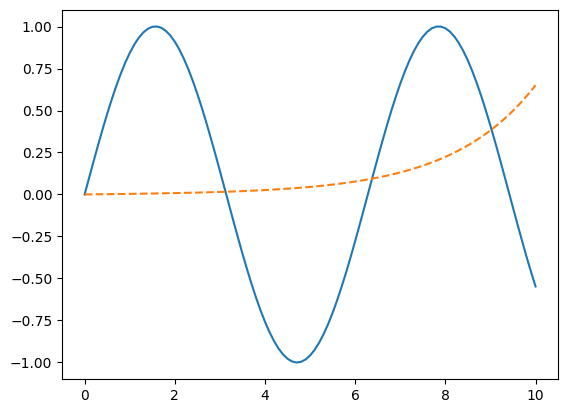

In [20]:
plot_comparison(jnp.array())

In [22]:
grad(loss_fn)(jnp.array([42.46559042, -79.90039241, -80.6826354, 149.18030614]), expected_q, expected_pi)

Array([0.75322428, 0.31366708, 0.31366708, 0.07214336], dtype=float64)

In [23]:
variation_range = np.linspace(-1, 1, 100)

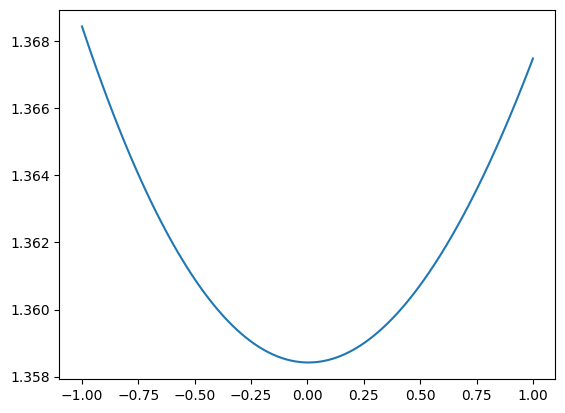

In [24]:
plt.plot(
    variation_range,
    [loss_fn(jnp.array([42.46559042, -79.90039241, -80.6826354, 149.18030614]) + jnp.array([0, 0, 0, x]), expected_q,
             expected_pi) for x in variation_range]
)

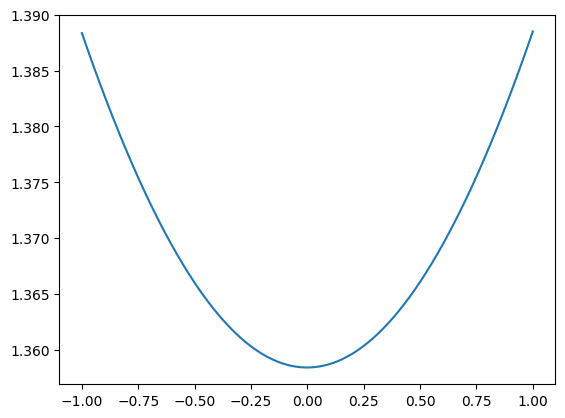

In [25]:
plt.plot(
    variation_range,
    [loss_fn(jnp.array([42.46559042, -79.90039241, -80.6826354, 149.18030614]) + jnp.array([0, 0, x, 0]), expected_q,
             expected_pi) for x in variation_range]
)

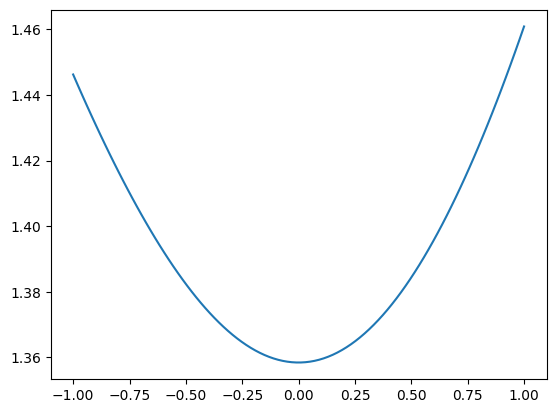

In [28]:
plt.plot(
    variation_range,
    [loss_fn(jnp.array([42.46559042, -79.90039241, -80.6826354, 149.18030614]) + jnp.array([x, 0, 0, 0]), expected_q,
             expected_pi) for x in variation_range]
)

In [31]:
def plot_variation_graph(embedding, local_variation_range = variation_range):
    plt.subplot(2, 2, 1)
    plt.plot(
        local_variation_range,
        [loss_fn(embedding + jnp.array([x, 0, 0, 0]), expected_q, expected_pi) for x in local_variation_range]
    )
    plt.subplot(2, 2, 2)
    plt.plot(
        local_variation_range,
        [loss_fn(embedding + jnp.array([0, x, 0, 0]), expected_q, expected_pi) for x in local_variation_range]
    )
    plt.subplot(2, 2, 3)
    plt.plot(
        local_variation_range,
        [loss_fn(embedding + jnp.array([0, 0, x, 0]), expected_q, expected_pi) for x in local_variation_range]
    )
    plt.subplot(2, 2, 4)
    plt.plot(
        local_variation_range,
        [loss_fn(embedding + jnp.array([0, 0, 0, x]), expected_q, expected_pi) for x in local_variation_range]
    )
    plt.show()

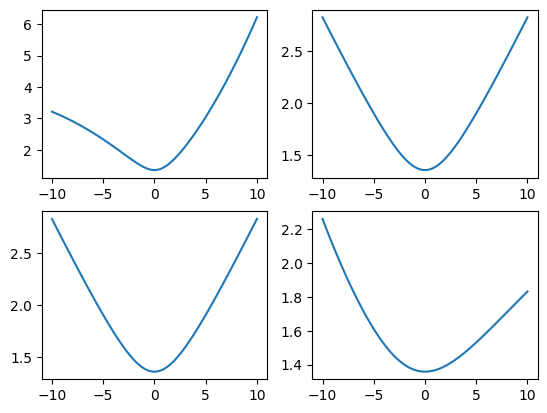

In [34]:
plot_variation_graph(jnp.array([ 42.46559042, -79.90039241, -80.6826354 , 149.18030614]), np.linspace(-10, 10, 100))

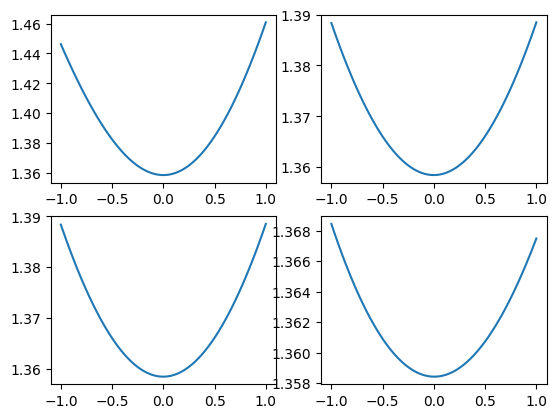

In [37]:
plot_variation_graph(jnp.array([ 42.46559042, -79.90039241, -80.6826354 , 149.18030614]))

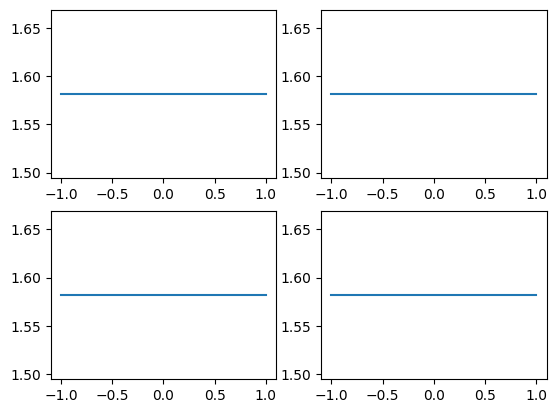

In [35]:
plot_variation_graph(results)

# Inspecting the behaviour of the loss function around the true embedding

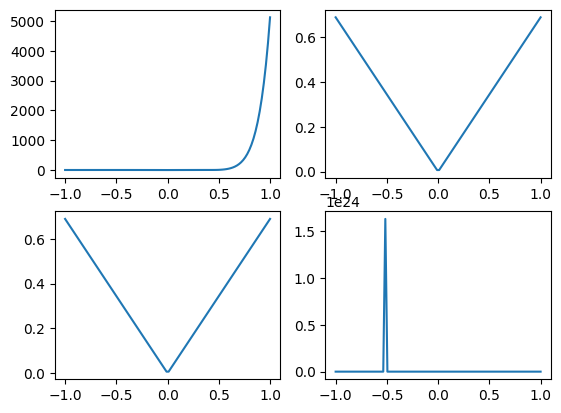

In [39]:
plot_variation_graph(true_embedding)

Okay something I note is that:

1. The loss function around the true embedding is not symmetric in the diagonal coordinates (the ones that are not zero in and of themselves).
2. The loss function may not be differentiable in thw off-diagonal coordinates at the true embedding.
3. The loss function's behaviour in the off-diagonal coordinates is flat in the proposed solution, but not in the true embedding.

INFO: jaxopt.GradientDescent: Iter: 1 Distance btw Iterates (stop. crit.): 18950.845861738995 Stepsize:3.814697265625e-06 
INFO: jaxopt.GradientDescent: Iter: 2 Distance btw Iterates (stop. crit.): 8222.033661310646 Stepsize:7.62939453125e-06 
INFO: jaxopt.GradientDescent: Iter: 3 Distance btw Iterates (stop. crit.): 4690.594969664238 Stepsize:1.52587890625e-05 
INFO: jaxopt.GradientDescent: Iter: 4 Distance btw Iterates (stop. crit.): 2564.4435967031095 Stepsize:3.0517578125e-05 
INFO: jaxopt.GradientDescent: Iter: 5 Distance btw Iterates (stop. crit.): 1364.0740238778624 Stepsize:6.103515625e-05 
INFO: jaxopt.GradientDescent: Iter: 6 Distance btw Iterates (stop. crit.): 708.6081370009416 Stepsize:0.0001220703125 
INFO: jaxopt.GradientDescent: Iter: 7 Distance btw Iterates (stop. crit.): 358.45568337762654 Stepsize:0.000244140625 
INFO: jaxopt.GradientDescent: Iter: 8 Distance btw Iterates (stop. crit.): 173.91742751603314 Stepsize:0.00048828125 
INFO: jaxopt.GradientDescent: Iter: 9 

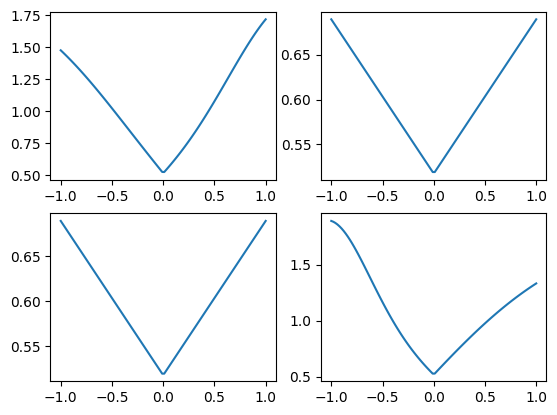

[-2.00598404  0.2450138  -0.24503647  2.00598782]


In [40]:
r1 = jaxopt.GradientDescent(
    loss_fn,
    maxiter=1000,
    verbose=True,
    maxls=100
).run(
    jnp.array(np.random.rand((2 * dof) ** 2)),
    expected_q,
    expected_pi
).params
plot_variation_graph(r1)
print(r1)

Okay here we actually converged to something, the values are not ~infinite, and we have reached a non-flat region of the loss function.

I expect this shows a large degree of dependence on the initial conditions. Overall, this isn't a terrible fit, we have the right period and all that

Its even almost symmetric and almost equal on the diagonal, if flipped sign. It's off by a constant factor, but its the right kind of form.

I suppose the real question is why did it converge to this, and not keep going? It didn't reach its maxiters value

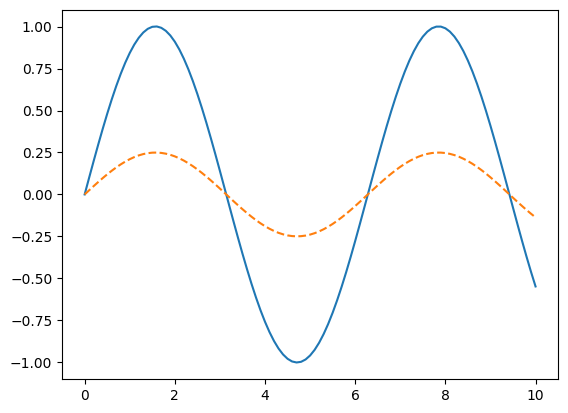

In [42]:
plot_comparison(r1)

In [58]:
np.array(true_embedding)

array([-0.5,  0. ,  0. ,  0.5])

In [59]:
np.array(r1)

array([-2.00598404,  0.2450138 , -0.24503647,  2.00598782])

In [60]:
gd = jaxopt.GradientDescent(
    loss_fn,
    maxiter=500,
    verbose=True,
    maxls=100
)

In [61]:
gdr1 = gd.run(
    jnp.array(np.random.rand((2 * dof) ** 2)),
    expected_q,
    expected_pi
)

INFO: jaxopt.GradientDescent: Iter: 1 Distance btw Iterates (stop. crit.): 1406.3493177672128 Stepsize:6.103515625e-05 
INFO: jaxopt.GradientDescent: Iter: 2 Distance btw Iterates (stop. crit.): 436.99534382219224 Stepsize:0.0001220703125 
INFO: jaxopt.GradientDescent: Iter: 3 Distance btw Iterates (stop. crit.): 226.68472407906515 Stepsize:0.000244140625 
INFO: jaxopt.GradientDescent: Iter: 4 Distance btw Iterates (stop. crit.): 99.33556008343919 Stepsize:0.00048828125 
INFO: jaxopt.GradientDescent: Iter: 5 Distance btw Iterates (stop. crit.): 32.64942611023645 Stepsize:0.0009765625 
INFO: jaxopt.GradientDescent: Iter: 6 Distance btw Iterates (stop. crit.): 11.132518868574628 Stepsize:0.001953125 
INFO: jaxopt.GradientDescent: Iter: 7 Distance btw Iterates (stop. crit.): 4.777622083515322 Stepsize:0.00390625 
INFO: jaxopt.GradientDescent: Iter: 8 Distance btw Iterates (stop. crit.): 3.0748110917270615 Stepsize:0.0078125 
INFO: jaxopt.GradientDescent: Iter: 9 Distance btw Iterates (sto

[-1.39986483  0.00200471 -0.00200722  1.39986479]


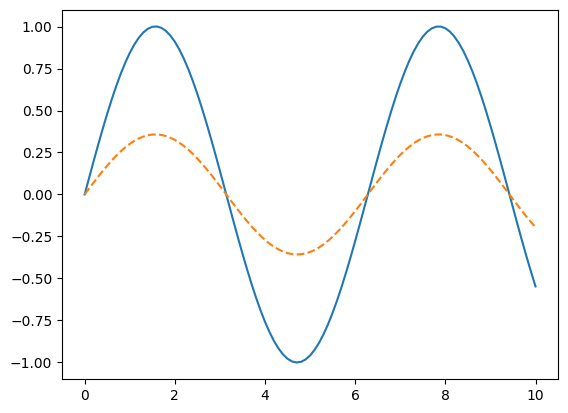

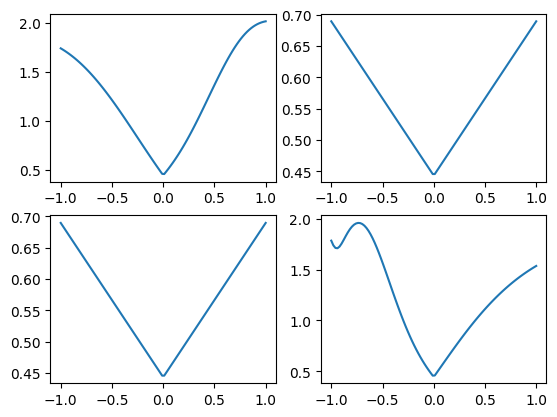

array([[-1.39986483,  0.00200471],
       [-0.00200722,  1.39986479]])

In [66]:
print(gdr1.params)
plot_comparison(gdr1.params)
plot_variation_graph(gdr1.params)
np.array(gdr1.params).reshape((2 * dof, 2 * dof))

Again we are converging to the same form!!!! Fucking hell!!

INFO: jaxopt.GradientDescent: Iter: 1 Distance btw Iterates (stop. crit.): 0.01972695488506226 Stepsize:1.0 
INFO: jaxopt.GradientDescent: Iter: 2 Distance btw Iterates (stop. crit.): 0.01747828465418404 Stepsize:1.0 
INFO: jaxopt.GradientDescent: Iter: 3 Distance btw Iterates (stop. crit.): 0.02148753770408104 Stepsize:1.0 
INFO: jaxopt.GradientDescent: Iter: 4 Distance btw Iterates (stop. crit.): 0.04203633154005621 Stepsize:1.0 
INFO: jaxopt.GradientDescent: Iter: 5 Distance btw Iterates (stop. crit.): 0.0476740687745316 Stepsize:1.0 
INFO: jaxopt.GradientDescent: Iter: 6 Distance btw Iterates (stop. crit.): 0.06416193508338819 Stepsize:1.0 
INFO: jaxopt.GradientDescent: Iter: 7 Distance btw Iterates (stop. crit.): 0.08319163958622926 Stepsize:1.0 
INFO: jaxopt.GradientDescent: Iter: 8 Distance btw Iterates (stop. crit.): 0.10832294923992346 Stepsize:1.0 
INFO: jaxopt.GradientDescent: Iter: 9 Distance btw Iterates (stop. crit.): 26770.227651548023 Stepsize:7.62939453125e-06 
INFO: j

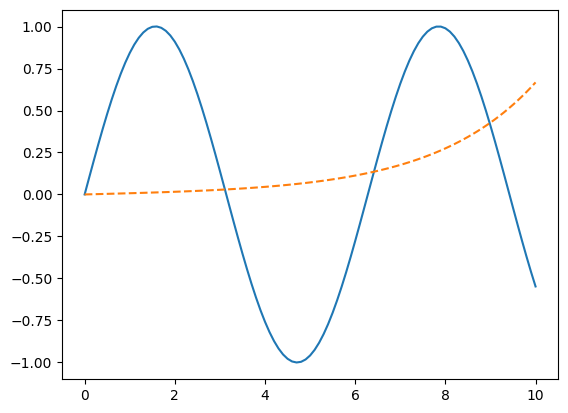

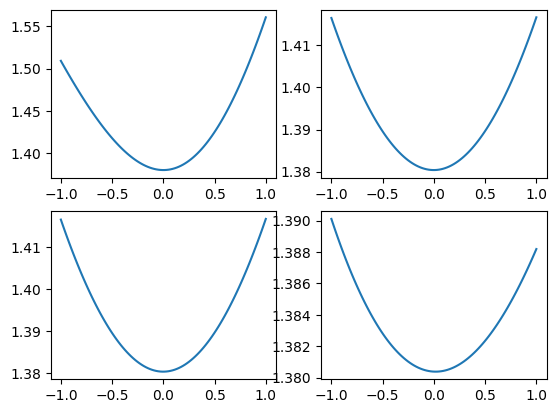

array([[ 14.08523709, -32.18767366],
       [-32.45099202,  71.44867725]])

In [68]:
gdr2 = gd.run(
    jnp.array(np.random.rand((2 * dof) ** 2)),
    expected_q,
    expected_pi
)
print(gdr2.params)
plot_comparison(gdr2.params)
plot_variation_graph(gdr2.params)
np.array(gdr2.params).reshape((2 * dof, 2 * dof))

In [89]:
def mega_comp(embedding):
    local_variation_range = variation_range

    # Create a gridspec instance with 2 rows and 3 columns
    gs = gridspec.GridSpec(2, 4)
    
    # Create a figure
    fig = plt.figure(figsize=(16,8))
    
    # Add four smaller subplots in the first two columns
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])

    # And a larger subplot in the third column
    ax5 = fig.add_subplot(gs[:, 2:])
    
    ax1.set_title("LF, emb[0]")
    ax1.plot(
        local_variation_range,
        [loss_fn(embedding + jnp.array([x, 0, 0, 0]), expected_q, expected_pi) for x in local_variation_range]
    )

    ax2.set_title("LF, emb[1]")
    ax2.plot(
        local_variation_range,
        [loss_fn(embedding + jnp.array([0, x, 0, 0]), expected_q, expected_pi) for x in local_variation_range]
    )
    
    ax3.set_title("LF, emb[2]")
    ax3.plot(
        local_variation_range,
        [loss_fn(embedding + jnp.array([0, 0, x, 0]), expected_q, expected_pi) for x in local_variation_range]
    )
    
    ax4.set_title("LF, emb[3]")
    ax4.plot(
        local_variation_range,
        [loss_fn(embedding + jnp.array([0, 0, 0, x]), expected_q, expected_pi) for x in local_variation_range]
    )
    
    ax5.set_title("Trajectories")
    ax5.plot(
        t, expected_q
    )
    
    ax5.plot(
        t, embedded_system_solver.integrate(
            q0=q0,
            pi0=pi0,
            t0=t0,
            iterations=iterations,
            additional_data=embedding
        )[0], linestyle='dashed'
    )
    
    plt.show()
    
    return np.array(embedding).reshape((2 * dof, 2 * dof))

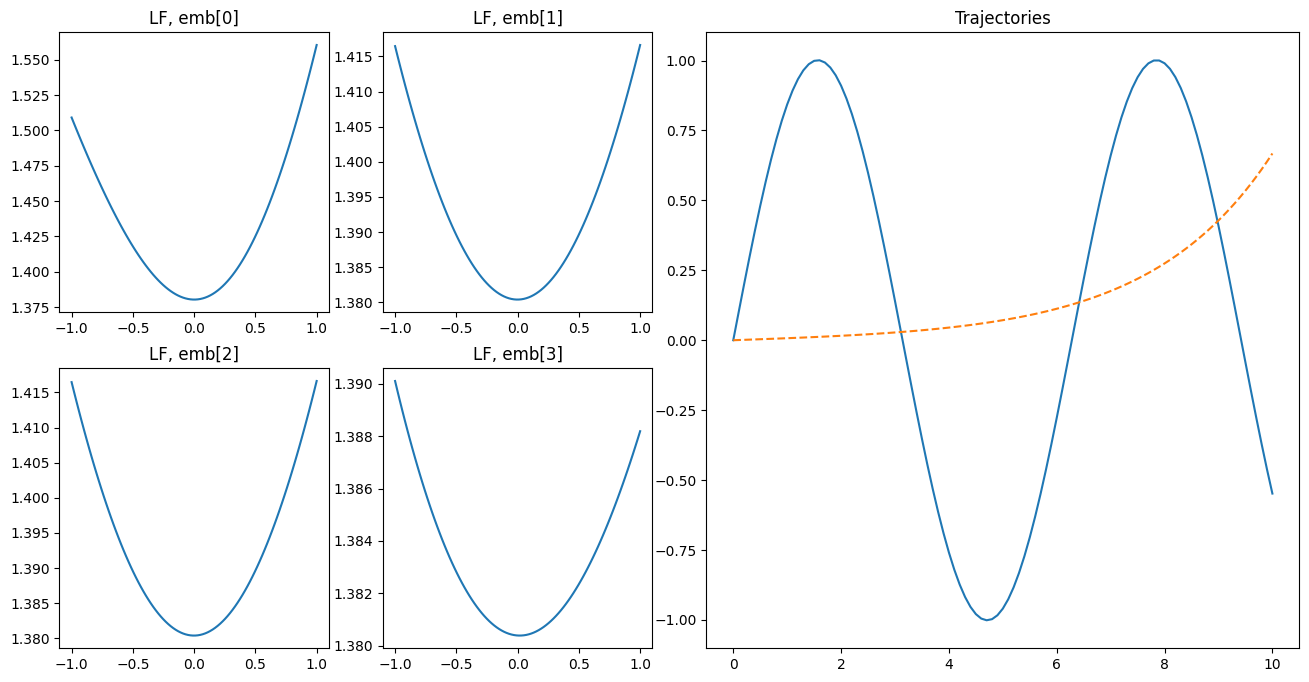

array([[ 14.08523709, -32.18767366],
       [-32.45099202,  71.44867725]])

In [90]:
mega_comp(gdr2.params)

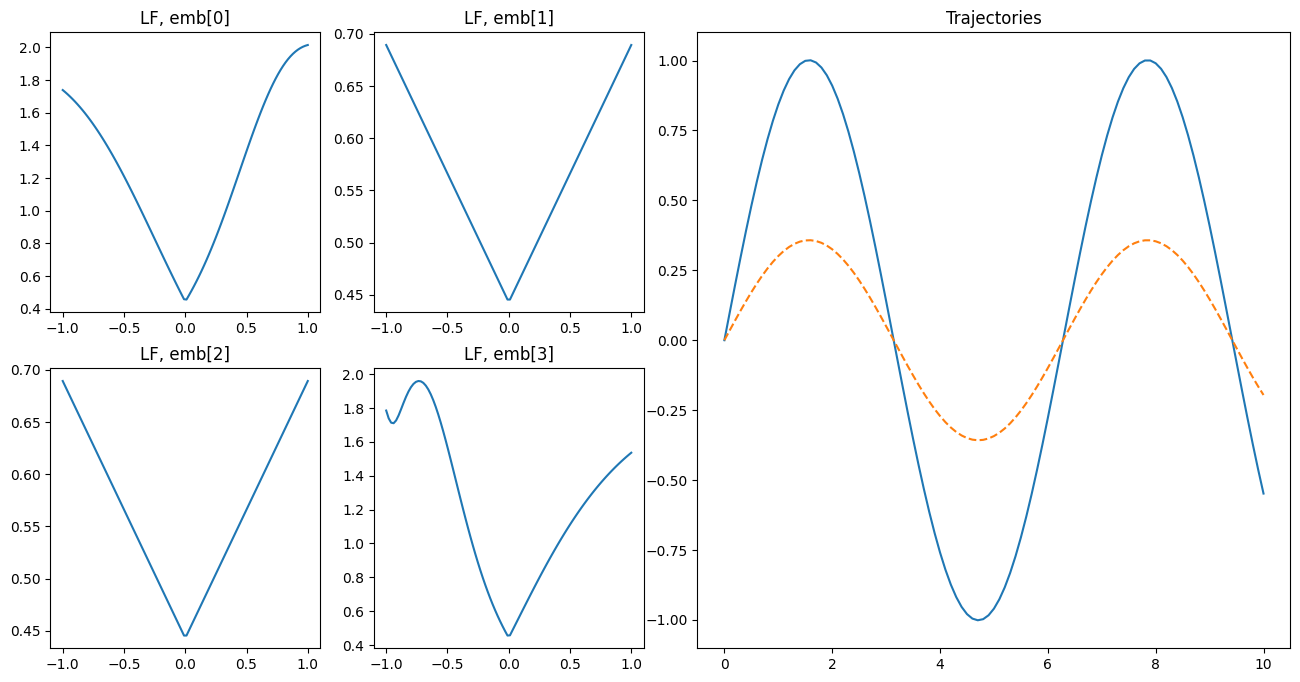

array([[-1.39986483,  0.00200471],
       [-0.00200722,  1.39986479]])

In [91]:
mega_comp(gdr1.params)

INFO: jaxopt.GradientDescent: Iter: 1 Distance btw Iterates (stop. crit.): 25219.742757596894 Stepsize:3.814697265625e-06 
INFO: jaxopt.GradientDescent: Iter: 2 Distance btw Iterates (stop. crit.): 9270.947881680351 Stepsize:7.62939453125e-06 
INFO: jaxopt.GradientDescent: Iter: 3 Distance btw Iterates (stop. crit.): 5290.08912335576 Stepsize:1.52587890625e-05 
INFO: jaxopt.GradientDescent: Iter: 4 Distance btw Iterates (stop. crit.): 2901.522923310628 Stepsize:3.0517578125e-05 
INFO: jaxopt.GradientDescent: Iter: 5 Distance btw Iterates (stop. crit.): 1551.892055130033 Stepsize:6.103515625e-05 
INFO: jaxopt.GradientDescent: Iter: 6 Distance btw Iterates (stop. crit.): 812.787015914958 Stepsize:0.0001220703125 
INFO: jaxopt.GradientDescent: Iter: 7 Distance btw Iterates (stop. crit.): 416.24918264832496 Stepsize:0.000244140625 
INFO: jaxopt.GradientDescent: Iter: 8 Distance btw Iterates (stop. crit.): 206.78392020781564 Stepsize:0.00048828125 
INFO: jaxopt.GradientDescent: Iter: 9 Dist

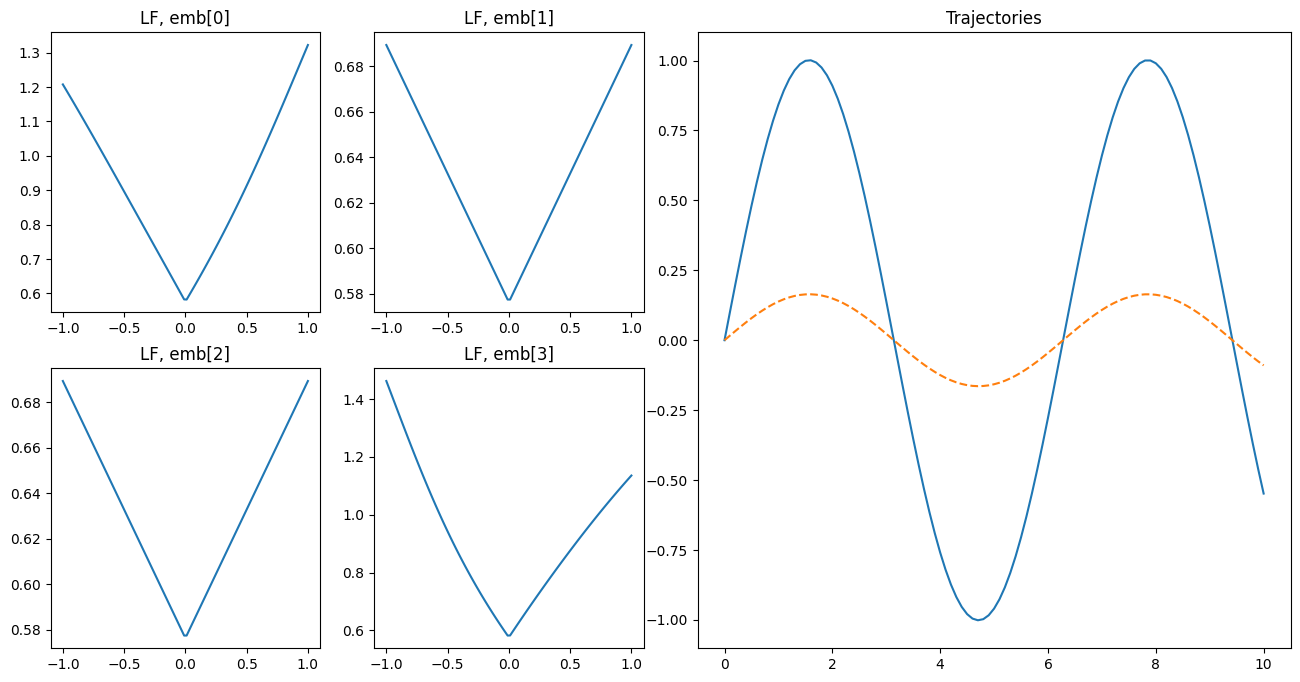

array([[-3.04743876, -0.19299466],
       [ 0.19297917,  3.04744123]])

In [93]:
gdr3 = gd.run(
    jnp.array(np.random.rand((2 * dof) ** 2)),
    expected_q,
    expected_pi
)
mega_comp(gdr3.params)

In [95]:
np.array(true_embedding).reshape((2 * dof, 2 * dof)) / gdr3.params.reshape((2 * dof, 2 * dof))

Array([[ 0.16407221, -0.        ],
       [ 0.        ,  0.16407207]], dtype=float64)

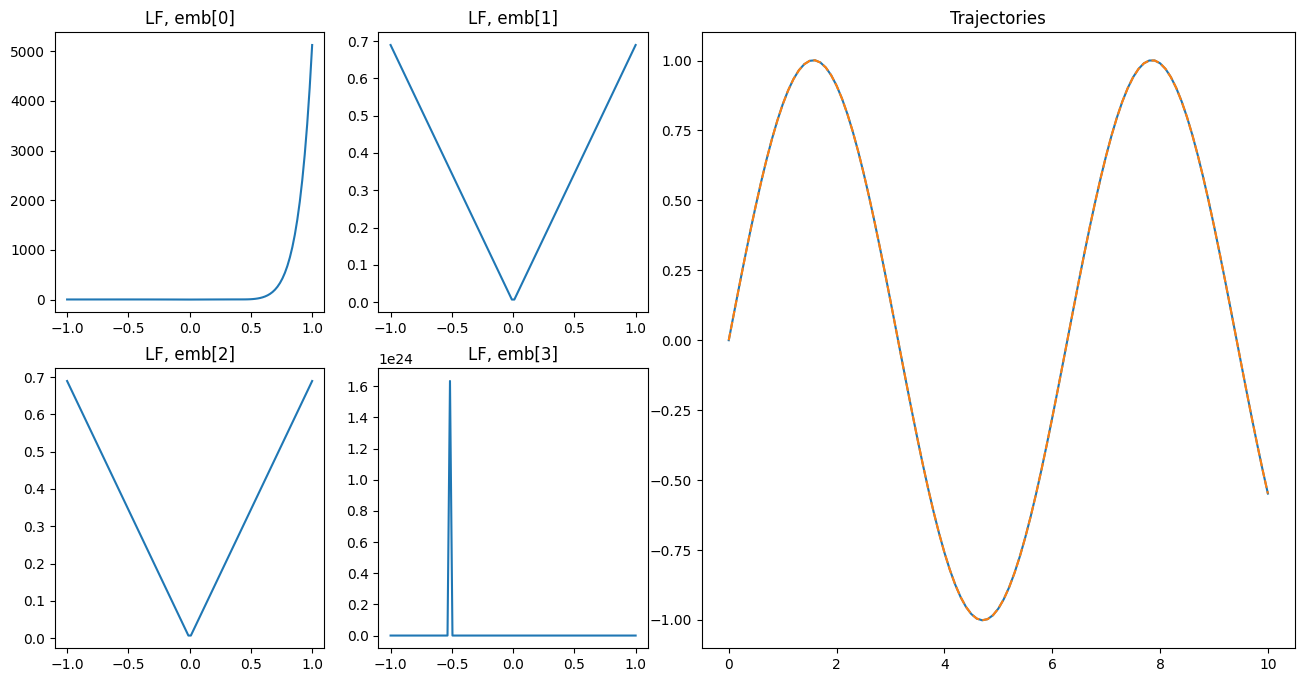

array([[-0.50000001, -0.03166506],
       [ 0.03166252,  0.50000042]])

In [96]:
mega_comp(gdr3.params * 0.16407221)

INFO: jaxopt.GradientDescent: Iter: 1 Distance btw Iterates (stop. crit.): 4940.486363266749 Stepsize:1.52587890625e-05 
INFO: jaxopt.GradientDescent: Iter: 2 Distance btw Iterates (stop. crit.): 2139.000582526991 Stepsize:3.0517578125e-05 
INFO: jaxopt.GradientDescent: Iter: 3 Distance btw Iterates (stop. crit.): 1192.82923690878 Stepsize:6.103515625e-05 
INFO: jaxopt.GradientDescent: Iter: 4 Distance btw Iterates (stop. crit.): 630.0549920519812 Stepsize:0.0001220703125 
INFO: jaxopt.GradientDescent: Iter: 5 Distance btw Iterates (stop. crit.): 318.22670121229885 Stepsize:0.000244140625 
INFO: jaxopt.GradientDescent: Iter: 6 Distance btw Iterates (stop. crit.): 150.67616461467108 Stepsize:0.00048828125 
INFO: jaxopt.GradientDescent: Iter: 7 Distance btw Iterates (stop. crit.): 59.87150819921587 Stepsize:0.0009765625 
INFO: jaxopt.GradientDescent: Iter: 8 Distance btw Iterates (stop. crit.): 21.612355802612043 Stepsize:0.001953125 
INFO: jaxopt.GradientDescent: Iter: 9 Distance btw It

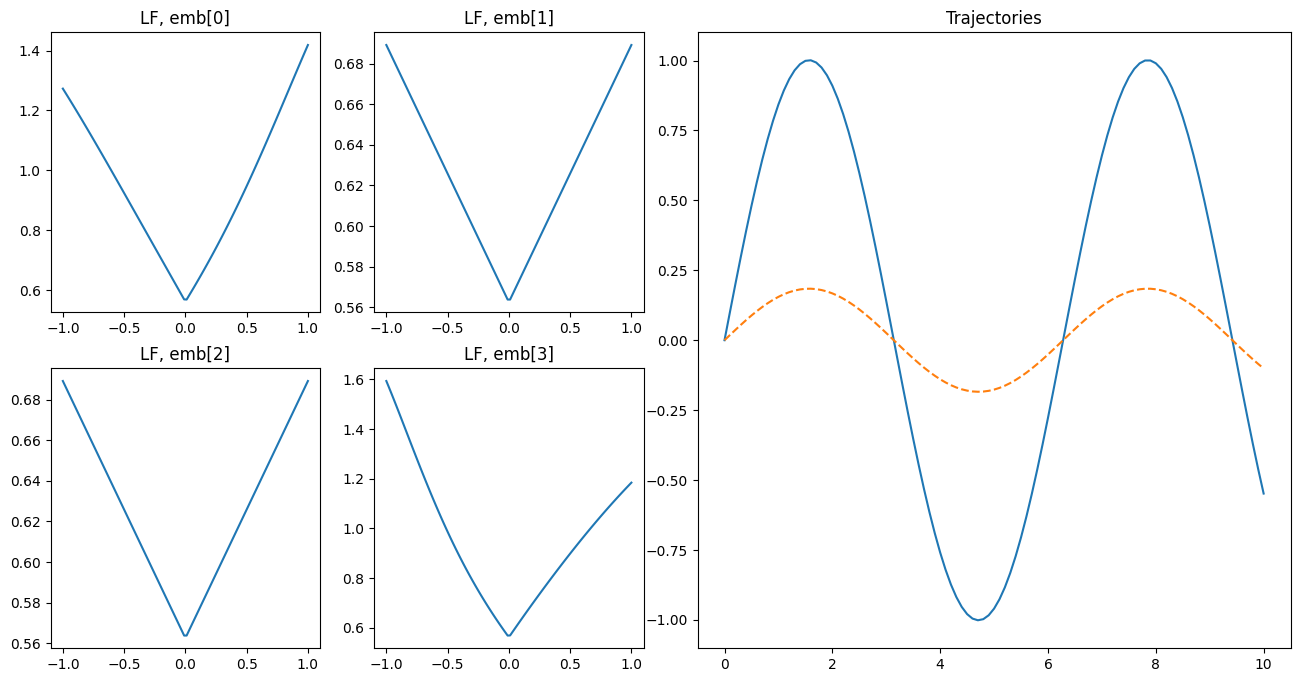

Array([[ 0.18401887, -0.        ],
       [ 0.        ,  0.18401869]], dtype=float64)

In [97]:
gdr4 = gd.run(
    jnp.array(np.random.rand((2 * dof) ** 2)),
    expected_q,
    expected_pi
)
mega_comp(gdr4.params)
np.array(true_embedding).reshape((2 * dof, 2 * dof)) / gdr4.params.reshape((2 * dof, 2 * dof))

In [109]:
def make_an_attempt():
    emb_i = jnp.array(np.random.rand((2 * dof) ** 2))
    print(f"Starting from: {emb_i}")
    
    gdr = gd.run(
        jnp.array(np.random.rand((2 * dof) ** 2)),
        expected_q,
        expected_pi
    )
    
    mega_comp(gdr.params)
    print("Got to: ", gdr.params)
    
    print("Off by a factor of {}".format(np.array(true_embedding).reshape((2 * dof, 2 * dof)) / gdr.params.reshape((2 * dof, 2 * dof))))
    return gdr

Starting from: [0.16387199 0.02718124 0.67128845 0.73349452]
INFO: jaxopt.GradientDescent: Iter: 1 Distance btw Iterates (stop. crit.): 0.07439178488296927 Stepsize:1.0 
INFO: jaxopt.GradientDescent: Iter: 2 Distance btw Iterates (stop. crit.): 0.09693220010597689 Stepsize:1.0 
INFO: jaxopt.GradientDescent: Iter: 3 Distance btw Iterates (stop. crit.): 0.10976646249941265 Stepsize:1.0 
INFO: jaxopt.GradientDescent: Iter: 4 Distance btw Iterates (stop. crit.): 29251.228662714944 Stepsize:7.62939453125e-06 
INFO: jaxopt.GradientDescent: Iter: 5 Distance btw Iterates (stop. crit.): 9926.529567275216 Stepsize:1.52587890625e-05 
INFO: jaxopt.GradientDescent: Iter: 6 Distance btw Iterates (stop. crit.): 3913.9420148472836 Stepsize:3.0517578125e-05 
INFO: jaxopt.GradientDescent: Iter: 7 Distance btw Iterates (stop. crit.): 1754.9431308852065 Stepsize:6.103515625e-05 
INFO: jaxopt.GradientDescent: Iter: 8 Distance btw Iterates (stop. crit.): 864.2583638219716 Stepsize:0.0001220703125 
INFO: jax

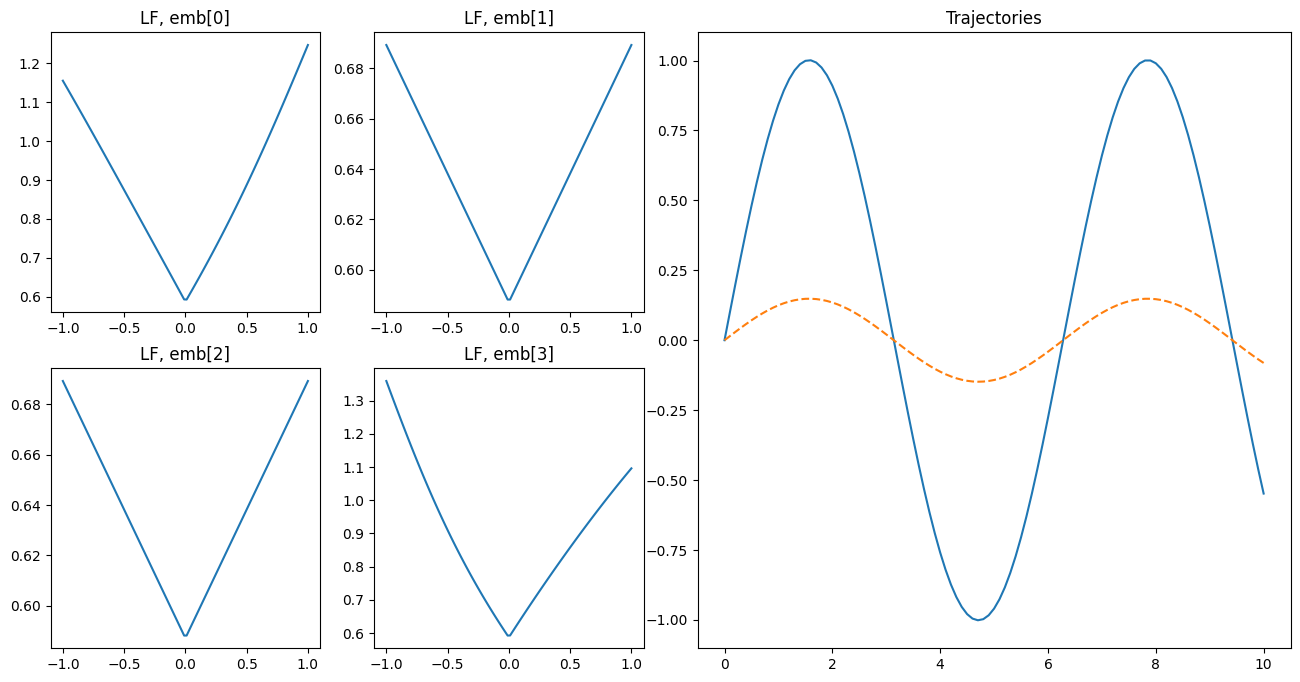

Got to:  [-3.37407596 -0.39515805  0.39517158  3.37407404]
Off by a factor of [[ 0.14818872 -0.        ]
 [ 0.          0.14818881]]


In [107]:
make_an_attempt()

Note that the factor off values in that are wrong, the code was referencing gdr4

Starting from: [0.82312812 0.68389639 0.27698142 0.54082392]
INFO: jaxopt.GradientDescent: Iter: 1 Distance btw Iterates (stop. crit.): 0.1382886096486258 Stepsize:1.0 
INFO: jaxopt.GradientDescent: Iter: 2 Distance btw Iterates (stop. crit.): 20122.334084757822 Stepsize:7.62939453125e-06 
INFO: jaxopt.GradientDescent: Iter: 3 Distance btw Iterates (stop. crit.): 7236.643792649612 Stepsize:1.52587890625e-05 
INFO: jaxopt.GradientDescent: Iter: 4 Distance btw Iterates (stop. crit.): 3595.0135398669827 Stepsize:3.0517578125e-05 
INFO: jaxopt.GradientDescent: Iter: 5 Distance btw Iterates (stop. crit.): 1906.6633931836752 Stepsize:6.103515625e-05 
INFO: jaxopt.GradientDescent: Iter: 6 Distance btw Iterates (stop. crit.): 1014.7091749418474 Stepsize:0.0001220703125 
INFO: jaxopt.GradientDescent: Iter: 7 Distance btw Iterates (stop. crit.): 532.1166772508963 Stepsize:0.000244140625 
INFO: jaxopt.GradientDescent: Iter: 8 Distance btw Iterates (stop. crit.): 272.59494905761176 Stepsize:0.0004

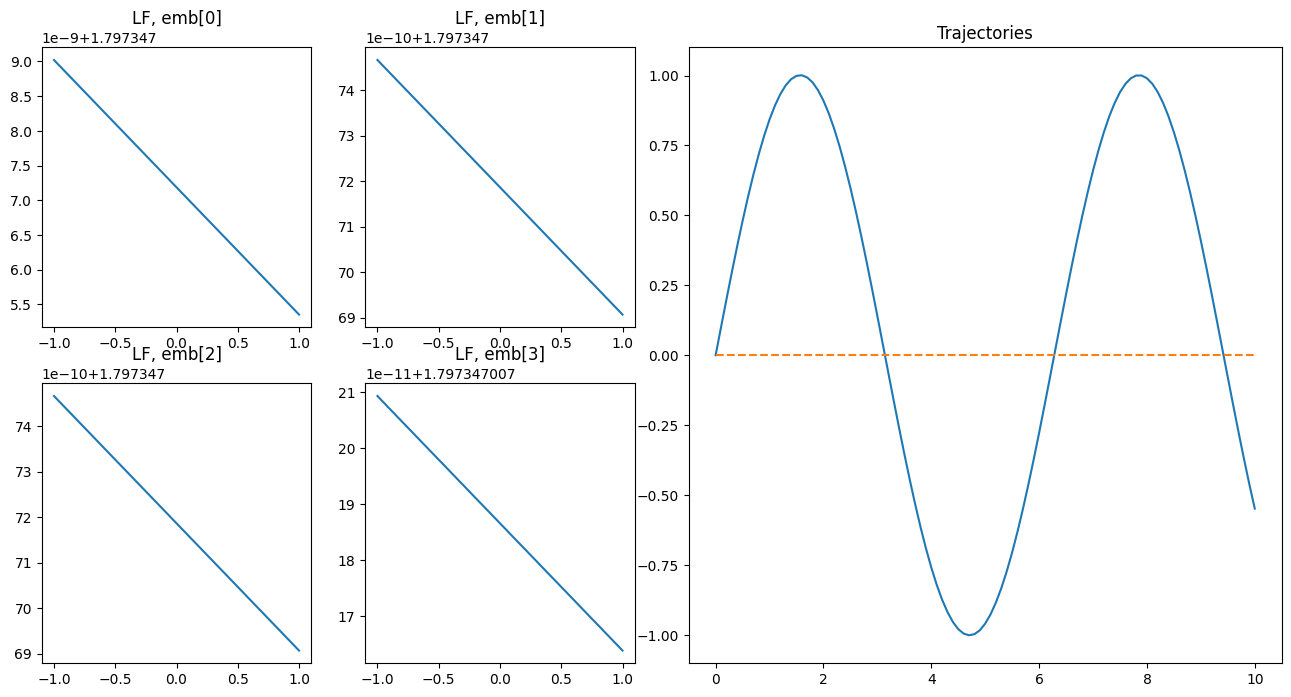

Got to:  [ 7.60802799e+07  3.71457876e+06  3.71457895e+06 -6.21224518e+09]
Off by a factor of [[-6.57200527e-09  0.00000000e+00]
 [ 0.00000000e+00 -8.04861986e-11]]


In [108]:
make_an_attempt()